In [1]:
import numpy as np
import pandas as pd
import os
import pycountry_convert as pc
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML, Javascript
from string import Template
import json
import IPython.display


In [2]:
fifaDf = pd.read_csv("CompleteDataset.csv")
fifaDf.head()

C:\Users\Rohit Nikam\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (20,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,...,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
0,0,Cristiano Ronaldo,32,Portugal,94,94,Real Madrid CF,€95.5M,€565K,2228,...,61.0,53.0,82.0,62.0,91.0,89.0,92.0,91.0,66.0,92.0
1,1,L. Messi,30,Argentina,93,93,FC Barcelona,€105M,€565K,2154,...,57.0,45.0,84.0,59.0,92.0,90.0,88.0,91.0,62.0,88.0
2,2,Neymar,25,Brazil,92,94,Paris Saint-Germain,€123M,€280K,2100,...,59.0,46.0,79.0,59.0,88.0,87.0,84.0,89.0,64.0,84.0
3,3,L. Suárez,30,Uruguay,92,92,FC Barcelona,€97M,€510K,2291,...,64.0,58.0,80.0,65.0,88.0,85.0,88.0,87.0,68.0,88.0
4,4,M. Neuer,31,Germany,92,92,FC Bayern Munich,€61M,€230K,1493,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The dataset has the following properties:

    -> Every player featuring in FIFA 18
    -> 70+ attributes
    -> Player and Flag Images
    -> Playing Position Data
    -> Attributes based on actual data of the latest EA's FIFA 18 game
    -> Attributes include on all player style statistics like Dribbling, Aggression, GK Skills etc.
    -> Player personal data like Nationality, Photo, Club, Age, Wage, Salary etc.

In [3]:
fifaDf.columns

Index(['Unnamed: 0', 'Name', 'Age', 'Nationality', 'Overall', 'Potential',
       'Club', 'Value', 'Wage', 'Special', 'Acceleration', 'Aggression',
       'Agility', 'Balance', 'Ball control', 'Composure', 'Crossing', 'Curve',
       'Dribbling', 'Finishing', 'Free kick accuracy', 'GK diving',
       'GK handling', 'GK kicking', 'GK positioning', 'GK reflexes',
       'Heading accuracy', 'Interceptions', 'Jumping', 'Long passing',
       'Long shots', 'Marking', 'Penalties', 'Positioning', 'Reactions',
       'Short passing', 'Shot power', 'Sliding tackle', 'Sprint speed',
       'Stamina', 'Standing tackle', 'Strength', 'Vision', 'Volleys', 'CAM',
       'CB', 'CDM', 'CF', 'CM', 'ID', 'LAM', 'LB', 'LCB', 'LCM', 'LDM', 'LF',
       'LM', 'LS', 'LW', 'LWB', 'Preferred Positions', 'RAM', 'RB', 'RCB',
       'RCM', 'RDM', 'RF', 'RM', 'RS', 'RW', 'RWB', 'ST'],
      dtype='object')

In [4]:
fifaDf.fillna(0, inplace=True)
fifaDf["Value"] = fifaDf["Value"].str.split('€').str.get(1)
fifaDf["Wage"] = fifaDf["Wage"].str.split('€').str.get(1)

In [5]:
def convert_to_numeric(num):    
    ints = []
    for x in num:
        if 'M' in x:
            ints.append(int(float(x.split('M')[0]) * 10**6))
        elif 'K' in x:
            ints.append(int(float(x.split('K')[0]) * 10**3))
        else:
            ints.append(x)
    return ints

fifaDf["Value"]=convert_to_numeric(fifaDf["Value"].astype(str))
fifaDf["Wage"]=convert_to_numeric(fifaDf["Wage"].astype(str)) 


In [6]:
fifaDf["Value"] = pd.to_numeric(fifaDf['Value'])
fifaDf["Wage"] = pd.to_numeric(fifaDf['Wage'])

## Data Cleaning and Manipulation

As the data had several inconsistencies and properties that made it unfit for appropriate exploratory analysis. In order to prepare the data, the following steps were performed:
•	The Wage and Value of all the players were in form of strings with the symbol of the currency in front of the values - €190K. These had to converted to numeric values.
•	The preferred positions of all the players was available as a space separated string (ST LW) which was converted to a list for easier retrieval.
•	A new attribute Preferred Positions was created by mapping the preferred positions of all the players with their respective roles in the team, like attack, midfielder, defence or goalkeeper.
•	Using the nationality of the players, a new attribute was created that contained the continent the player belonged to.


In [7]:
fifaDf.head()

,Unnamed: 0,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,...,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
0,0,Cristiano Ronaldo,32,Portugal,94,94,Real Madrid CF,95500000,565000,2228,...,61.0,53.0,82.0,62.0,91.0,89.0,92.0,91.0,66.0,92.0
1,1,L. Messi,30,Argentina,93,93,FC Barcelona,105000000,565000,2154,...,57.0,45.0,84.0,59.0,92.0,90.0,88.0,91.0,62.0,88.0
2,2,Neymar,25,Brazil,92,94,Paris Saint-Germain,123000000,280000,2100,...,59.0,46.0,79.0,59.0,88.0,87.0,84.0,89.0,64.0,84.0
3,3,L. Suárez,30,Uruguay,92,92,FC Barcelona,97000000,510000,2291,...,64.0,58.0,80.0,65.0,88.0,85.0,88.0,87.0,68.0,88.0
4,4,M. Neuer,31,Germany,92,92,FC Bayern Munich,61000000,230000,1493,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
fifaDf['Preferred Positions'] = fifaDf['Preferred Positions'].apply(lambda position: [x for x in position.split(' ') if x])

In [9]:
def positionSelector(temp):
    if temp[0] in ['CF','LS','LF','LW','RF','RS','ST','RW']:
        return 'Attacker'
    elif temp[0] in ['CAM','CM','CDM','LCM','LAM','LDM','LM','RAM','RCM','RDM','RM']:
        return 'Midfielder'
    elif temp[0] in ['CB','LCB','LB','LWB','RWB','RCB','RB']:
            return 'Defender'
    elif temp[0] in ['GK']:
        return 'GoalKeeper'
        

In [10]:
fifaDf['Field Positions']=fifaDf['Preferred Positions'].apply(positionSelector)

In [11]:
fifaDf['Field Positions'].value_counts()

Midfielder    7174
Defender      5440
Attacker      3338
GoalKeeper    2029
Name: Field Positions, dtype: int64

In [12]:
def nationalitySelector(temp):
    if temp in ['England', 'Republic of Ireland', 'Scotland','Wales','Northern Ireland','Kosovo','FYR Macedonia','Europe']:
        return 'United Kingdom'
    elif temp in ['Bosnia Herzegovina']:
        return 'Bosnia and Herzegovina'
    elif temp in ['Korea Republic','Korea DPR']:
        return 'South Korea'
    elif temp in ['DR Congo']:
        return 'Democratic Republic of the Congo'
    elif temp in ['China PR']:
        return 'China'
    elif temp in ['Guinea Bissau','Central African Rep.','São Tomé & Príncipe']:
        return 'South Africa'
    elif temp in ['Curacao', 'Trinidad & Tobago','St Kitts Nevis','Antigua & Barbuda','St Lucia']:
        return 'Argentina'
    else:
        return temp

In [13]:
fifaDf['Nationality'] = fifaDf['Nationality'].apply(nationalitySelector)

In [14]:
fifaDf['Nationality'].value_counts()

United Kingdom       2605
Germany              1140
Spain                1019
Argentina             994
France                978
Brazil                812
Italy                 799
Colombia              592
Japan                 469
Netherlands           429
United States         381
Chile                 375
Sweden                368
Portugal              367
Mexico                360
Denmark               346
Poland                337
South Korea           336
Norway                333
Saudi Arabia          329
Russia                306
Turkey                291
Belgium               272
Austria               266
Switzerland           233
Australia             227
Uruguay               153
Serbia                133
Senegal               129
Nigeria               126
                     ... 
Thailand                2
Mauritania              2
Tanzania                2
Sudan                   2
Ethiopia                2
Gibraltar               2
Puerto Rico             2
Cuba        

In [15]:
def continentSelector(temp):
    country_alpha2 = pc.country_name_to_country_alpha2(temp)
    #print(country_alpha2)
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    #print(country_continent_code)
    country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    return country_continent_name
    #print(country_continent_name)


In [16]:
fifaDf['Continent']=fifaDf['Nationality'].apply(continentSelector)


In [17]:
fifaDf['Continent'].value_counts()

Europe           10813
South America     3151
Asia              1632
Africa            1190
North America      926
Oceania            269
Name: Continent, dtype: int64

## Exploratory Data Analysis

After preparing the dataset for analysis, explorations were made on a macro level like continent and player nationality level analysis as well as on player level. Through the process attempts were made to derive interesting correlations and trends by the use of visualizations.

## Geographic distribution of players

Circle-packing is the arrangement of circles inside some demarcation so that none of the circles overlap. Circle packing also displays hierarchy where you can get smaller clusters of circles packed within a bigger circle which itself is arranged next to or within other circles. The D3.js plot will be interactive and dynamic, where one is able to invoke zoomable animations at different regions and clusters with the click of a mouse button. The D3.js plot will be interactive and dynamic, where one is able to invoke zoomable animations at different regions and clusters with the click of a mouse button. Each of the player’s nationality was mapped to its respective continent. There were 162 distinct Nationality values in the dataset and these countries were mapped to 6 continents: Asia, Europe, Africa, North America, South America and Australia/Oceania. In the plot, the 6 continents will be the parent class (outer circles). We can dive deeper within this class to find the countries (sub-class / sub-circles) and within each country, we will find the players (inner circles). The size of the player circle is determined by the Overall variable. A continent dictionary was created with the names of the continents as the keys and the list of countries as the values for each key. A function was defined to assign the continent for each country. The top 2000 players were chosen based on the overall value. Groupings of the players were hence identified using the Nationality and Continent. This grouping will be displayed with the circle graph plot and is fed into the json file. The data to be displayed is stored in the json file.

In [18]:
top_1000 = fifaDf.sort_values("Overall", ascending=False).reset_index().head(1000)[["Name", "Nationality", "Continent", "Overall", "Club"]]

In [19]:
Africa = top_1000[top_1000["Continent"]=='Africa']
Antarctica = top_1000[top_1000["Continent"]=='Antarctica']
Asia = top_1000[top_1000["Continent"]=='Asia']
Australia_Oceania =  top_1000[top_1000["Continent"]=='Australia_Oceania']
Europe = top_1000[top_1000["Continent"]=='Europe']
North_america = top_1000[top_1000["Continent"]=='North_america']
South_america = top_1000[top_1000["Continent"]=='South_america']

data = {}
data["name"] = "DISTRIBUTION OF TOP 1000 PLAERS DUE TO NATIONALITY"
data["children"] = []
# Split dataset into Continents:
for continent in top_1000['Continent'].unique():
    
    continent_set = top_1000[top_1000["Continent"]==continent]
    continent_dict = {}
    continent_dict["name"] = continent
    continent_dict["children"] = []
    
    for country in continent_set['Nationality'].unique():
        
        countries_set = continent_set[continent_set['Nationality']==country][['Name', 'Overall']]
        
        country_dict = {}
        country_dict["name"] = country
        country_dict["children"] = []
        
        for player in countries_set.values:
            
            player_dict = {}
            player_dict['name'] = player[0]
            player_dict['size'] = player[1]
            country_dict["children"].append(player_dict)
            
        continent_dict['children'].append(country_dict)
        
    data["children"].append(continent_dict)


In [20]:
North_america_dict = {}
North_america_dict['name'] = 'North_america'
North_america_dict['children'] = []
for country in North_america['Nationality'].unique():
    list_of_countries = North_america[North_america['Nationality']==country][['Name', 'Overall']].rename(columns={'Name': 'name', 'Overall': 'size'})
    tmp_dict = {}
    tmp_dict["name"] = country
    tmp_dict["children"] = []
    for row in list_of_countries.values:
        player_tmp = {}
        player_tmp['name'] = row[0]
        player_tmp['size'] = row[1]
        tmp_dict["children"].append(player_tmp)
    North_america_dict['children'].append(tmp_dict)

In [21]:
html_string = """
<!DOCTYPE html>
<meta charset="utf-8">
<style>

.node {
  cursor: pointer;
}

.node:hover {
  stroke: #000;
  stroke-width: 1.5px;
}

.node--leaf {
  fill: white;
}

.label {
  font: 11px "Helvetica Neue", Helvetica, Arial, sans-serif;
  text-anchor: middle;
  text-shadow: 0 1px 0 #fff, 1px 0 0 #fff, -1px 0 0 #fff, 0 -1px 0 #fff;
}

.label,
.node--root,
.node--leaf {
  pointer-events: none;
}

</style>
<svg width="800" height="800"></svg>
"""

In [22]:
js_string="""
 require.config({
    paths: {
        d3: "http://d3js.org/d3.v4.min"
     }
 });

  require(["d3"], function(d3) {

   console.log(d3);

var svg = d3.select("svg"),
    margin = 20,
    diameter = +svg.attr("width"),
    g = svg.append("g").attr("transform", "translate(" + diameter / 2 + "," + diameter / 2 + ")");

var color = d3.scaleSequential(d3.interpolatePlasma)
    .domain([-4, 4]);

var pack = d3.pack()
    .size([diameter - margin, diameter - margin])
    .padding(2);

d3.json("output.json", function(error, root) {
  if (error) throw error;

  root = d3.hierarchy(root)
      .sum(function(d) { return d.size; })
      .sort(function(a, b) { return b.value - a.value; });

  var focus = root,
      nodes = pack(root).descendants(),
      view;

  var circle = g.selectAll("circle")
    .data(nodes)
    .enter().append("circle")
      .attr("class", function(d) { return d.parent ? d.children ? "node" : "node node--leaf" : "node node--root"; })
      .style("fill", function(d) { return d.children ? color(d.depth) : null; })
      .on("click", function(d) { if (focus !== d) zoom(d), d3.event.stopPropagation(); });

  var text = g.selectAll("text")
    .data(nodes)
    .enter().append("text")
      .attr("class", "label")
      .style("fill-opacity", function(d) { return d.parent === root ? 1 : 0; })
      .style("display", function(d) { return d.parent === root ? "inline" : "none"; })
      .text(function(d) { return d.data.name; });

  var node = g.selectAll("circle,text");

  svg
      .style("background", color(-1))
      .on("click", function() { zoom(root); });

  zoomTo([root.x, root.y, root.r * 2 + margin]);

  function zoom(d) {
    var focus0 = focus; focus = d;

    var transition = d3.transition()
        .duration(d3.event.altKey ? 7500 : 750)
        .tween("zoom", function(d) {
          var i = d3.interpolateZoom(view, [focus.x, focus.y, focus.r * 2 + margin]);
          return function(t) { zoomTo(i(t)); };
        });

    transition.selectAll("text")
      .filter(function(d) { return d.parent === focus || this.style.display === "inline"; })
        .style("fill-opacity", function(d) { return d.parent === focus ? 1 : 0; })
        .on("start", function(d) { if (d.parent === focus) this.style.display = "inline"; })
        .on("end", function(d) { if (d.parent !== focus) this.style.display = "none"; });
  }

  function zoomTo(v) {
    var k = diameter / v[2]; view = v;
    node.attr("transform", function(d) { return "translate(" + (d.x - v[0]) * k + "," + (d.y - v[1]) * k + ")"; });
    circle.attr("r", function(d) { return d.r * k; });
  }
});
  });
 """

In [23]:
with open('output.json', 'w') as outfile:  
    json.dump(data, outfile)

![](FIFAD3.PNG)

This plot clearly shows the concentration of players across the continents. The size of the circles determines the number of top players in each region. Most of the top players are concentrated in Europe and South America. These two circles are significantly bigger than the other circles. Africa, Asia and North America have only few top players compared to Europe and South America though they are bigger in terms of size. This is clearly seen from the size of the circles. In Europe, Spain, Germany, France, Italy and Portugal have a very good number of top players. For South America, it is Brazil and Argentina. The distribution of top players across regions is useful in predicting the best team according to Nationality.

In [24]:
h = display(HTML(html_string))
j = IPython.display.Javascript(js_string)
IPython.display.display_javascript(j)

## Countries with the best aggregate player ratings

To explore which teams have the potential to surpass the current best, the following analysis was done. The top 10 countries by number of players were chosen and the overall and potential of their players were depicted as box plots.

In [25]:
overallRatings = fifaDf['Nationality'].value_counts()[:10].index.tolist()
overallRatings

['United Kingdom',
 'Germany',
 'Spain',
 'Argentina',
 'France',
 'Brazil',
 'Italy',
 'Colombia',
 'Japan',
 'Netherlands']

In [26]:
overallRatingsDf = fifaDf[['Nationality','Overall','Potential','Wage','Value','Club']].loc[fifaDf['Nationality'].isin(overallRatings)]
overallRatingsDf['Nationality'].value_counts()

United Kingdom    2605
Germany           1140
Spain             1019
Argentina          994
France             978
Brazil             812
Italy              799
Colombia           592
Japan              469
Netherlands        429
Name: Nationality, dtype: int64

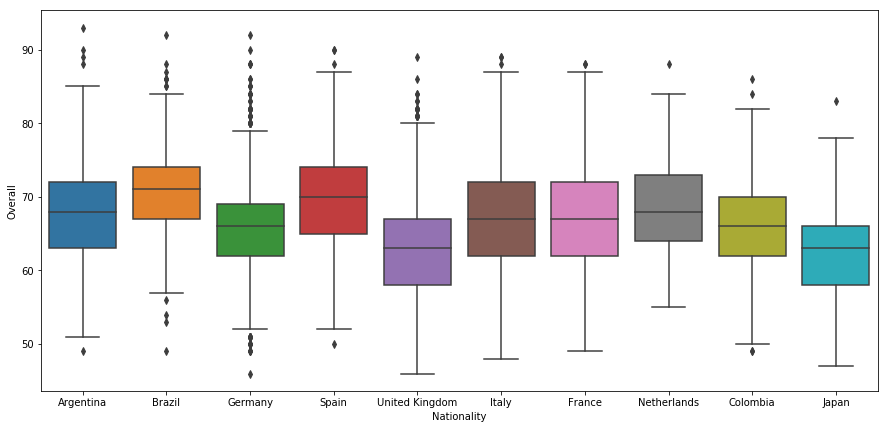

In [27]:
fig, ax = plt.subplots(figsize=(15,7))
sns.boxplot(ax=ax, x=overallRatingsDf["Nationality"], y=overallRatingsDf["Overall"] )


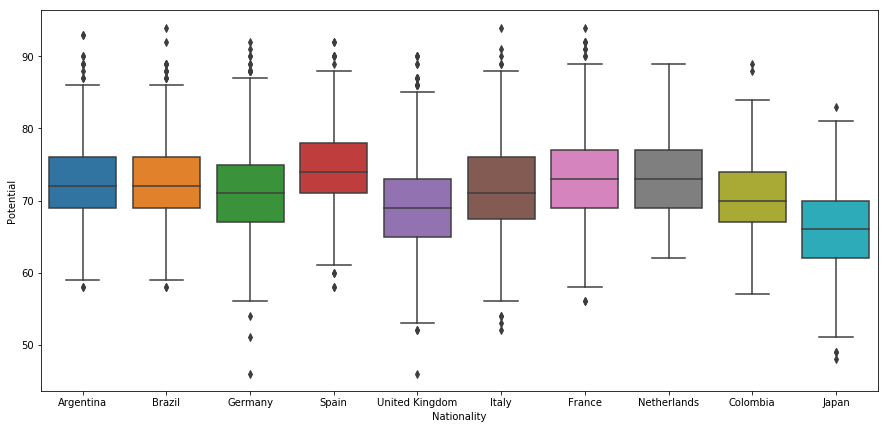

In [28]:
fig, ax = plt.subplots(figsize=(15,7))
sns.boxplot(ax=ax, x=overallRatingsDf["Nationality"], y=overallRatingsDf["Potential"] )


The mean overall is seen to be highest for Brazil followed by Spain, Argentina, Netherlands and France. However, in terms of potential, Spain seems to have overtaken Brazil, followed by Netherlands and France. This gives an indication about which teams are likely to perform better in the coming few years. Further ways in which this analysis can be improved is by plotting box plots against the highly and mildly correlated attributes that we saw above to reveal which are the attributes a country’s players are focusing on and make changes in their strategy if deemed fit.

## Countries with the best Wages and Value of the players

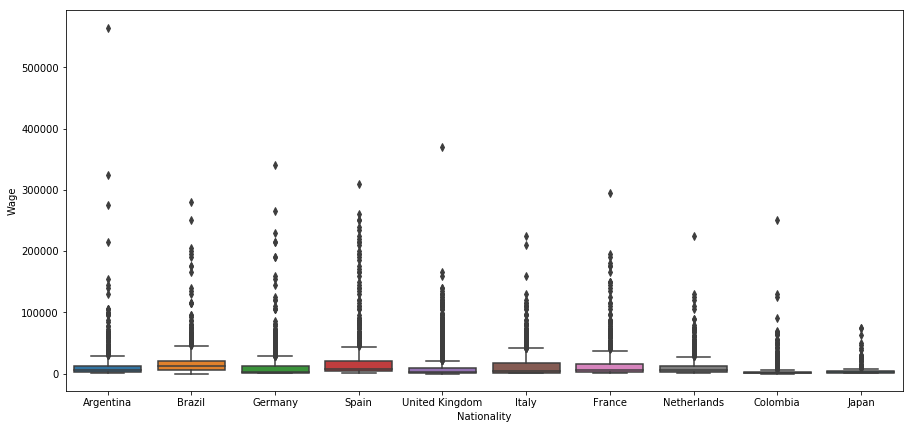

In [29]:
fig, ax = plt.subplots(figsize=(15,7))
sns.boxplot(ax=ax, x=overallRatingsDf["Nationality"], y=overallRatingsDf["Wage"] )


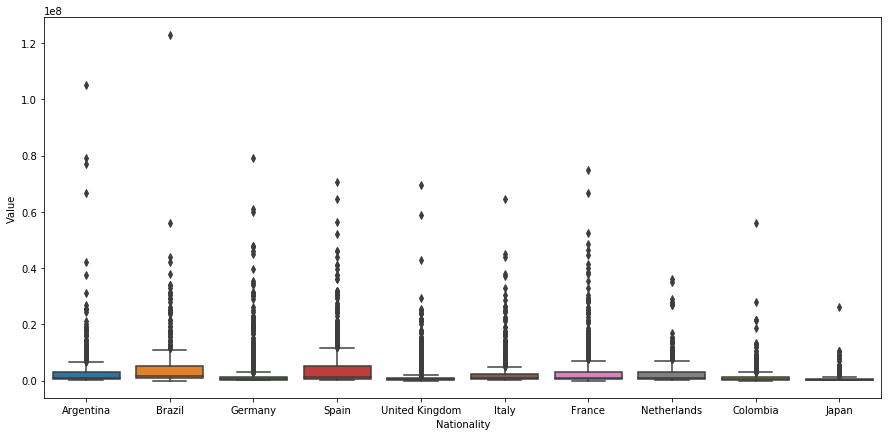

In [30]:
fig, ax = plt.subplots(figsize=(15,7))
sns.boxplot(ax=ax, x=overallRatingsDf["Nationality"], y=overallRatingsDf["Value"] )


The mean overall is seen to be highest for Spain followed by Brazil, Italy, France and Germany. However, in terms of value, Spain again tops the list, followed by Brazil and Argentina. This gives an indication about which countries are valued most. 

### Analysis of players overall rating and wages

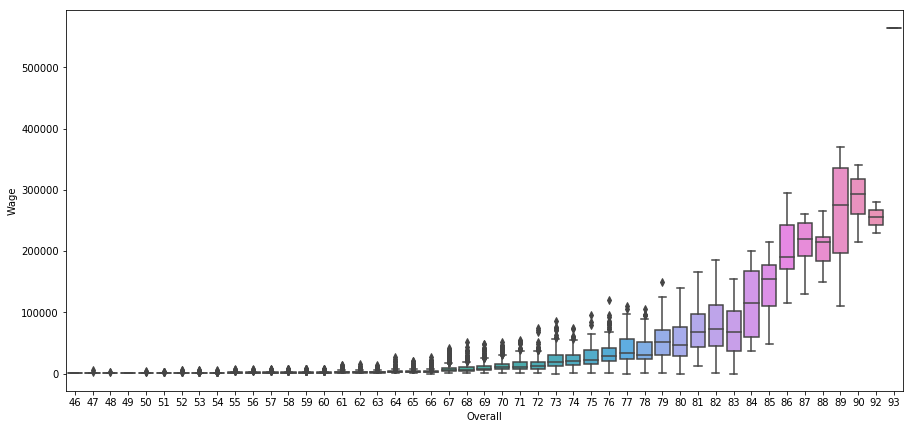

In [31]:
fig, ax = plt.subplots(figsize=(15,7))
sns.boxplot(ax=ax, x=overallRatingsDf["Overall"], y=overallRatingsDf["Wage"] )


We observe that as overall increases the wages of the players also increases. But we also observe that in many cases few of the players even having less overall rating is earning more wage compared to the player having higher overall rating.

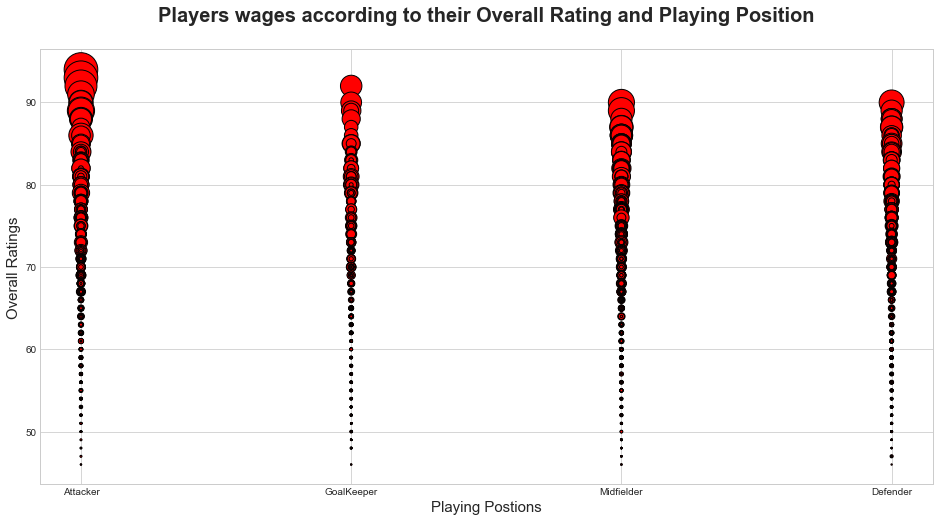

In [32]:
plt.figure(figsize=(16,8))
sns.set_style("whitegrid")
plt.title('Players wages according to their Overall Rating and Playing Position', fontsize=20, fontweight='bold', y=1.05,)
plt.xlabel('Playing Postions', fontsize=15)
plt.ylabel('Overall Ratings', fontsize=15)

pos = fifaDf["Field Positions"].values
overall = fifaDf["Overall"].values
value = fifaDf["Wage"].values

plt.scatter(pos, overall, s = value/500, edgecolors='black', color="red")
plt.show()

From the above plot we can say the reason for the above dilemma is due to attackers having more wages compared to other players playing at different positions.

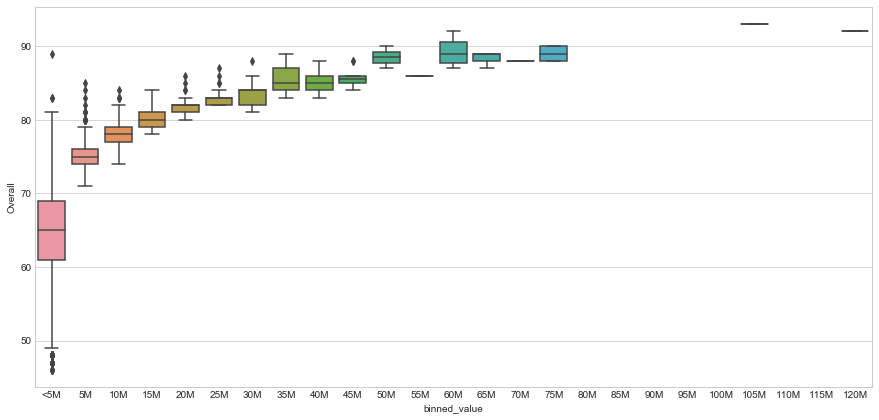

In [33]:
bins = range(-1,max(overallRatingsDf['Value'])+5000000,5000000)
#len(bins)
labels = ['<5M','5M','10M','15M','20M','25M','30M','35M','40M','45M','50M','55M','60M','65M','70M','75M','80M','85M','90M','95M','100M','105M','110M','115M','120M']
#len(labels)
overallRatingsDf['binned_value'] = pd.cut(overallRatingsDf['Value'], bins=bins, labels=labels)
#fifaDf['binned']
fig, ax = plt.subplots(figsize=(15,7))
sns.boxplot(ax=ax, x=overallRatingsDf["binned_value"], y=overallRatingsDf["Overall"])

## Player earnings at top clubs

A quick way to understand which clubs command the highest salaries is to plot the wages as a box-plot. This gives all the important statistical metrics as well as the spread about the mean.To do this analysis, the top 10 clubs by median overall rating were chosen and their wages depicted as box plots.

In [34]:
topClubsList = fifaDf.groupby('Club',sort=False)['Wage'].median()[:10].index.tolist()
#clubRatingsDf = fifaDf['Club'].value_counts()
#clubRatingsDf
topClubsList

['Real Madrid CF',
 'FC Barcelona',
 'Paris Saint-Germain',
 'FC Bayern Munich',
 'Manchester United',
 'Chelsea',
 'Juventus',
 'Manchester City',
 'Arsenal',
 'Atlético Madrid']

In [35]:
topClubsDf = fifaDf[['Nationality','Overall','Potential','Wage','Value','Club']].loc[fifaDf['Club'].isin(topClubsList)]

[Text(0, 0, 'Real Madrid CF'),
 Text(0, 0, 'FC Barcelona'),
 Text(0, 0, 'Paris Saint-Germain'),
 Text(0, 0, 'FC Bayern Munich'),
 Text(0, 0, 'Manchester United'),
 Text(0, 0, 'Chelsea'),
 Text(0, 0, 'Juventus'),
 Text(0, 0, 'Manchester City'),
 Text(0, 0, 'Arsenal'),
 Text(0, 0, 'Atlético Madrid')]

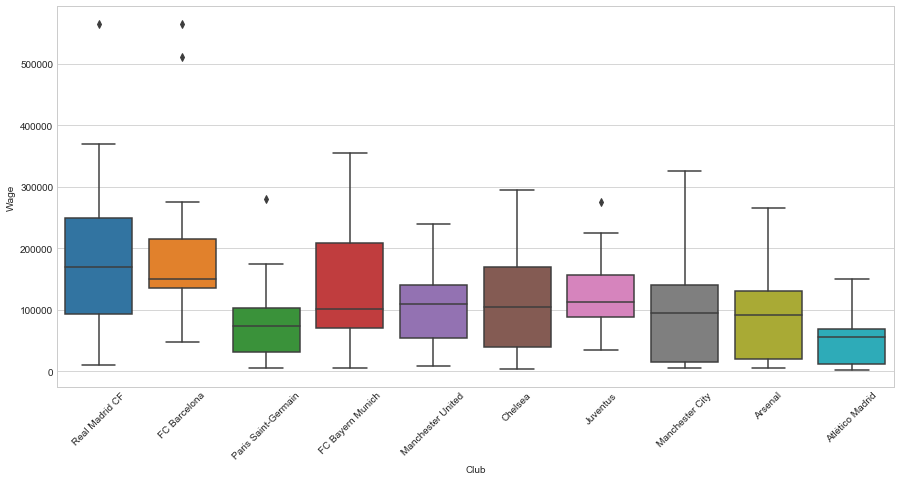

In [36]:
fig, ax = plt.subplots(figsize=(15,7))
plot = sns.boxplot(ax=ax, x=topClubsDf["Club"], y=topClubsDf["Wage"] )
plot.set_xticklabels(plot.get_xticklabels(),rotation=45)

[Text(0, 0, 'Real Madrid CF'),
 Text(0, 0, 'FC Barcelona'),
 Text(0, 0, 'Paris Saint-Germain'),
 Text(0, 0, 'FC Bayern Munich'),
 Text(0, 0, 'Manchester United'),
 Text(0, 0, 'Chelsea'),
 Text(0, 0, 'Juventus'),
 Text(0, 0, 'Manchester City'),
 Text(0, 0, 'Arsenal'),
 Text(0, 0, 'Atlético Madrid')]

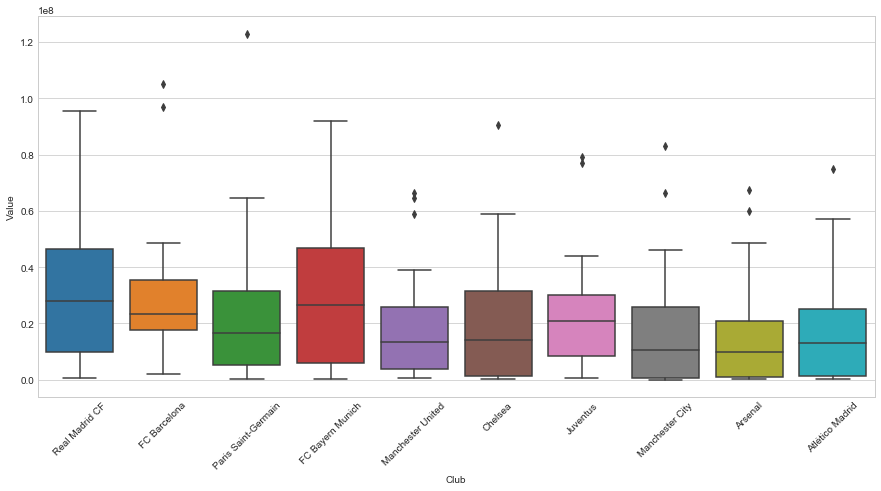

In [37]:
fig, ax = plt.subplots(figsize=(15,7))
plot = sns.boxplot(ax=ax, x=topClubsDf["Club"], y=topClubsDf["Value"] )
plot.set_xticklabels(plot.get_xticklabels(),rotation=45)

Real Madrid is seen to have the highest wage in terms of mean wage, followed by FC Barcelona and Manchester United and Manchester City. A real world application of this analysis can be used by players to decide which club they should strive for if they want a wage hike. Also in terms of most valuable players, Real Madrid and FC Bayern Munich seem to lead the pack.

## Clubs with the best aggregate player ratings 

The aggregate overall and potential rating were compared among and between the top 10 football clubs.The variation of overall rating and potential rating was then demonstrated for these clubs using boxplots. This gives an indication about which teams are likely to perform better in the coming few years. Further ways in which this analysis can be improved is by plotting box plots against the highly and mildly correlated attributes that we saw above to reveal which are the attributes a country’s players are focusing on and make changes in their strategy if deemed fit.

[Text(0, 0, 'Real Madrid CF'),
 Text(0, 0, 'FC Barcelona'),
 Text(0, 0, 'Paris Saint-Germain'),
 Text(0, 0, 'FC Bayern Munich'),
 Text(0, 0, 'Manchester United'),
 Text(0, 0, 'Chelsea'),
 Text(0, 0, 'Juventus'),
 Text(0, 0, 'Manchester City'),
 Text(0, 0, 'Arsenal'),
 Text(0, 0, 'Atlético Madrid')]

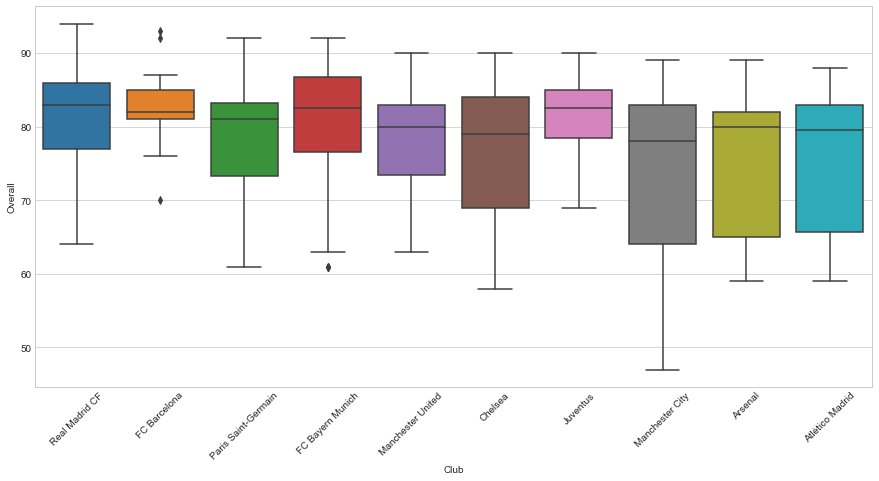

In [38]:
fig, ax = plt.subplots(figsize=(15,7))
plot = sns.boxplot(ax=ax, x=topClubsDf["Club"], y=topClubsDf["Overall"] )
plot.set_xticklabels(plot.get_xticklabels(),rotation=45)

[Text(0, 0, 'Real Madrid CF'),
 Text(0, 0, 'FC Barcelona'),
 Text(0, 0, 'Paris Saint-Germain'),
 Text(0, 0, 'FC Bayern Munich'),
 Text(0, 0, 'Manchester United'),
 Text(0, 0, 'Chelsea'),
 Text(0, 0, 'Juventus'),
 Text(0, 0, 'Manchester City'),
 Text(0, 0, 'Arsenal'),
 Text(0, 0, 'Atlético Madrid')]

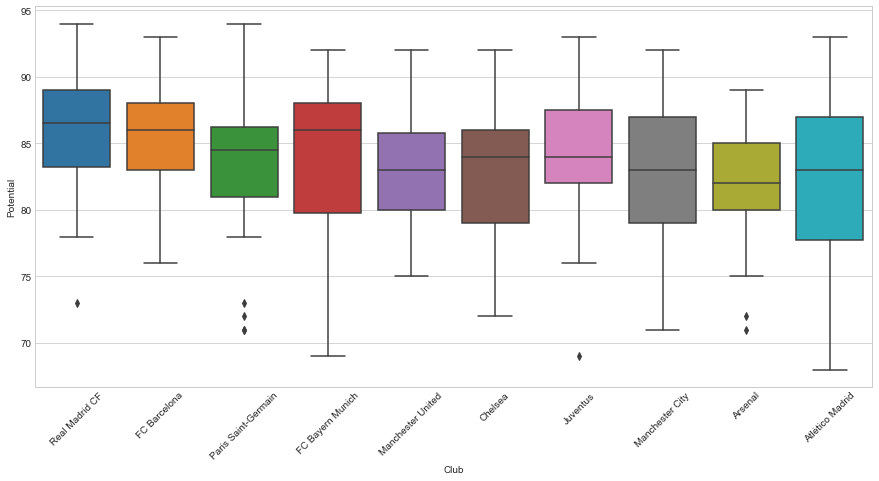

In [39]:
fig, ax = plt.subplots(figsize=(15,7))
plot = sns.boxplot(ax=ax, x=topClubsDf["Club"], y=topClubsDf["Potential"])
plot.set_xticklabels(plot.get_xticklabels(),rotation=45)

The mean overall is seen to be highest for Real Madrid followed by Juventus, FC Bayern Munich, FC Barcelona and Manchester City. However, in terms of potential, FC Barcelona seems to have overtaken Real Madrid, indicating a presence of a lot of young talent at the club.